In [15]:
import pandas as pd
file_path = './2019_ML_hardness.csv'
data = pd.read_csv(file_path)


In [17]:
display(data.head())

Al    Co    Cr    Cu    Fe    Ni  Hardness
0  18.2   9.1  18.2  18.2  18.2  18.2       473
1  18.2  18.2   9.1  18.2  18.2  18.2       367
2  18.2  18.2  18.2  18.2   9.1  18.2       418
3  18.2  18.2  18.2  18.2  18.2   9.1       423
4   5.3  21.1  21.1   0.0  26.3  26.3       168

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Al        155 non-null    float64
 1   Co        155 non-null    float64
 2   Cr        155 non-null    float64
 3   Cu        155 non-null    float64
 4   Fe        155 non-null    float64
 5   Ni        155 non-null    float64
 6   Hardness  155 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 8.6 KB


In [19]:
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler

scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(data)
print(data_scaled[4])

[0.11471861 0.49184149 0.3794964  0.         0.56076759 0.526
 0.08721805]


In [20]:
def weighted_mse(y_true, y_pred):
    import tensorflow as tf
    weights = tf.where(tf.abs(y_true) < 0.1, 2.0, 1.0)  # 為接近零的實際值增加權重
    return tf.reduce_mean(tf.square(y_true - y_pred) * weights)

In [21]:
# Auto-encoder model
from keras.models import Model
from keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

input_dim = data_scaled.shape[1]  

# # 使用 Sequential 建立編碼器
encoder = Sequential([
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),  # 使用整數除法確保單元數為整數
    Dense(8, activation='linear')
])

# 使用 Sequential 建立解碼器
decoder = Sequential([
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim, activation='linear')
])

# 定義輸入層的維度
input_layer = Input(shape=(input_dim,))
encoded_output = encoder(input_layer)
decoded_output = decoder(encoded_output)
autoencoder = Model(inputs=input_layer, outputs=decoded_output)
autoencoder.compile(optimizer='adam', loss=weighted_mse)


In [22]:
history = autoencoder.fit(data_scaled, data_scaled,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_split=0.2)


Epoch 1/100
13/13 [==============================] - 1s 21ms/step - loss: 0.1795 - val_loss: 0.1961
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1414 - val_loss: 0.1463
Epoch 3/100
13/13 [==============================] - 0s 6ms/step - loss: 0.1012 - val_loss: 0.1044
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0734 - val_loss: 0.0885
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0584 - val_loss: 0.0827
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0526 - val_loss: 0.0772
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0483 - val_loss: 0.0725
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0435 - val_loss: 0.0645
Epoch 9/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0376 - val_loss: 0.0591
Epoch 10/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0327 - val_loss: 0.0569
Epoch 11

## Model evaluation

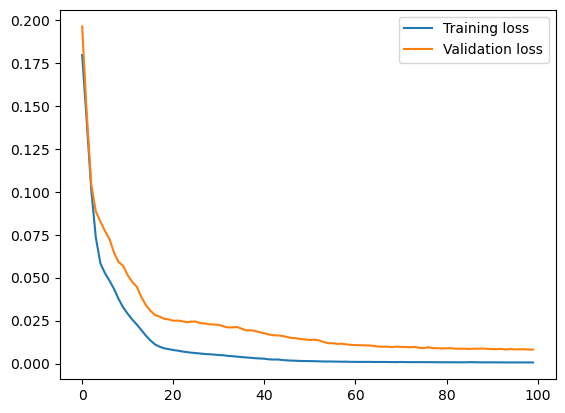

In [23]:
import matplotlib.pyplot as plt
# print the training histroy
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [24]:
# 使用模型進行預測
decoded_data = autoencoder.predict(data_scaled)
# 計算和顯示重構誤差
reconstruction_error = np.mean(np.power(data_scaled - decoded_data, 2), axis=1)
print("平均重構誤差:", np.mean(reconstruction_error))

5/5 [==============================] - 0s 2ms/step
平均重構誤差: 0.0017717178341177908


0


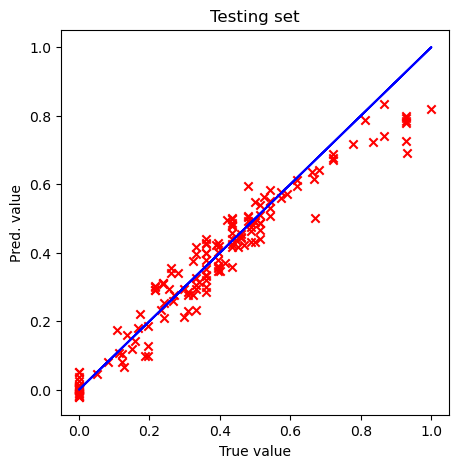

1


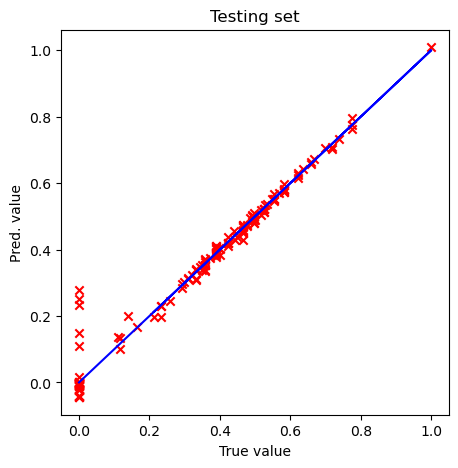

2


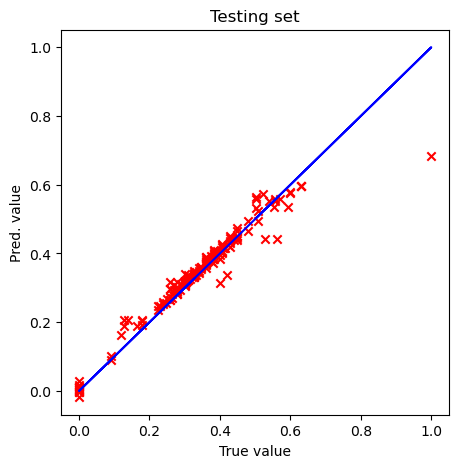

3


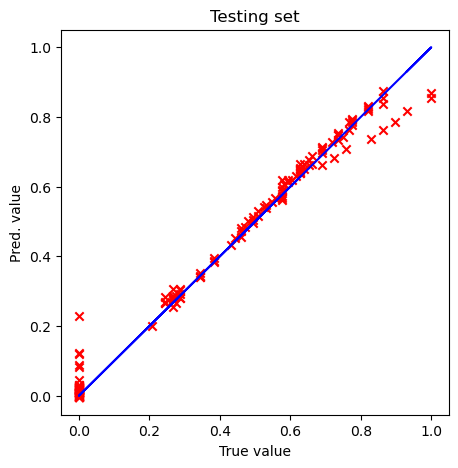

4


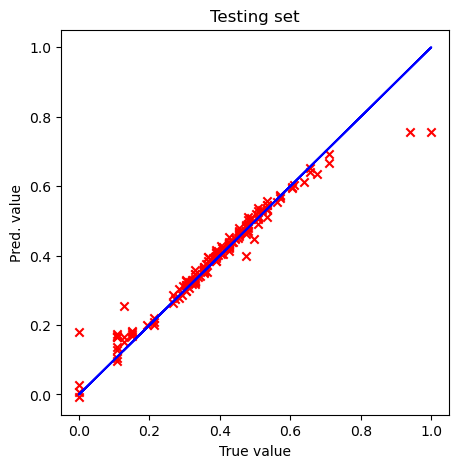

5


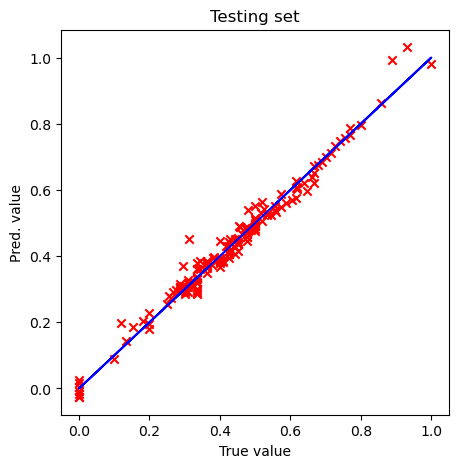

6


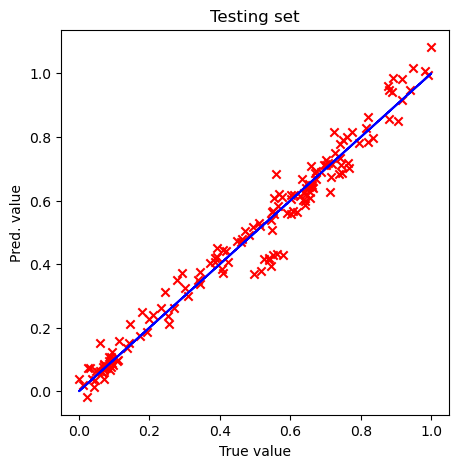

In [25]:
def plot_scatter (x, y, title, x_label, y_label,n):
    # plt.subplot(2, 2, n);
    plt.figure(figsize=(5, 5));
    plt.plot(x, x, color="blue", label="d")
    plt.scatter(x, y, marker="x", color="red")
    # plt.axis((0,210, 0,210))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

# y_pred = model.predict(x_test)
for i in range(0,decoded_data.shape[1]):
    print(i)
    plot_scatter(data_scaled[:,i], decoded_data[:,i], "Testing set", "True value", "Pred. value",1)

# y_pred = model.predict(x_train)
# plot_scatter(y_train, y_pred, "Training set", "True value", "Pred. value",2)


5/5 [==============================] - 0s 2ms/step


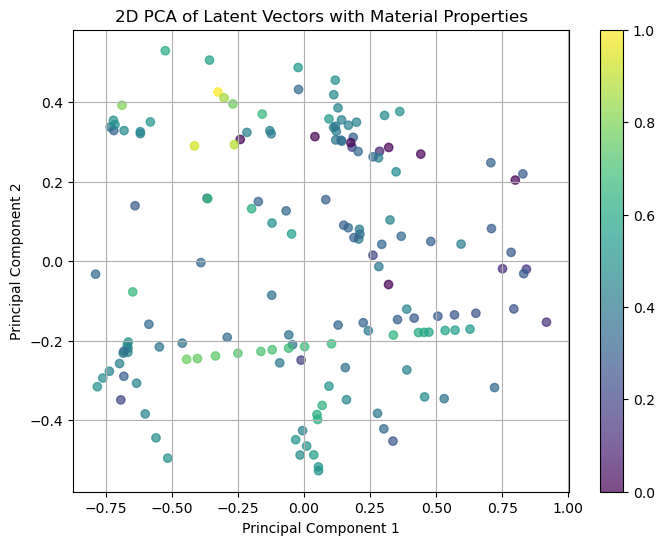

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 假設 encoder_model 是從autoencoder中提取的編碼部分
latent_vector = encoder.predict(data_scaled)
N_d =5

# 使用PCA將隱藏層的向量壓縮到2維
pca = PCA(n_components=2)
latent_vector_2d = pca.fit_transform(latent_vector)
material_properties = data_scaled[:,N_d]

# 視覺化
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_vector_2d[:, 0], latent_vector_2d[:, 1], alpha=0.7, c=material_properties, cmap='viridis')
plt.colorbar(scatter)  # 添加色條
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Latent Vectors with Material Properties')
plt.grid(True)
plt.show()


5/5 [==============================] - 0s 1ms/step
[[ 0.40215257  0.1968799   0.34244254 ...  0.39916974  0.3502649
   0.5393371 ]
 [ 0.35669056  0.41883102  0.18947841 ...  0.41054004  0.37364644
   0.41785476]
 [ 0.36263067  0.42089126  0.33293512 ...  0.20088269  0.38536757
   0.4777352 ]
 ...
 [ 0.31267712 -0.01988588  0.57339376 ...  0.16421708  0.50699323
   0.42828456]
 [ 0.3090596  -0.01868694  0.5635157  ...  0.17900763  0.49382728
   0.42709884]
 [ 0.3121902  -0.02363662  0.5596174  ...  0.16598159  0.5334162
   0.41364425]]


(-3.0, 3.0)

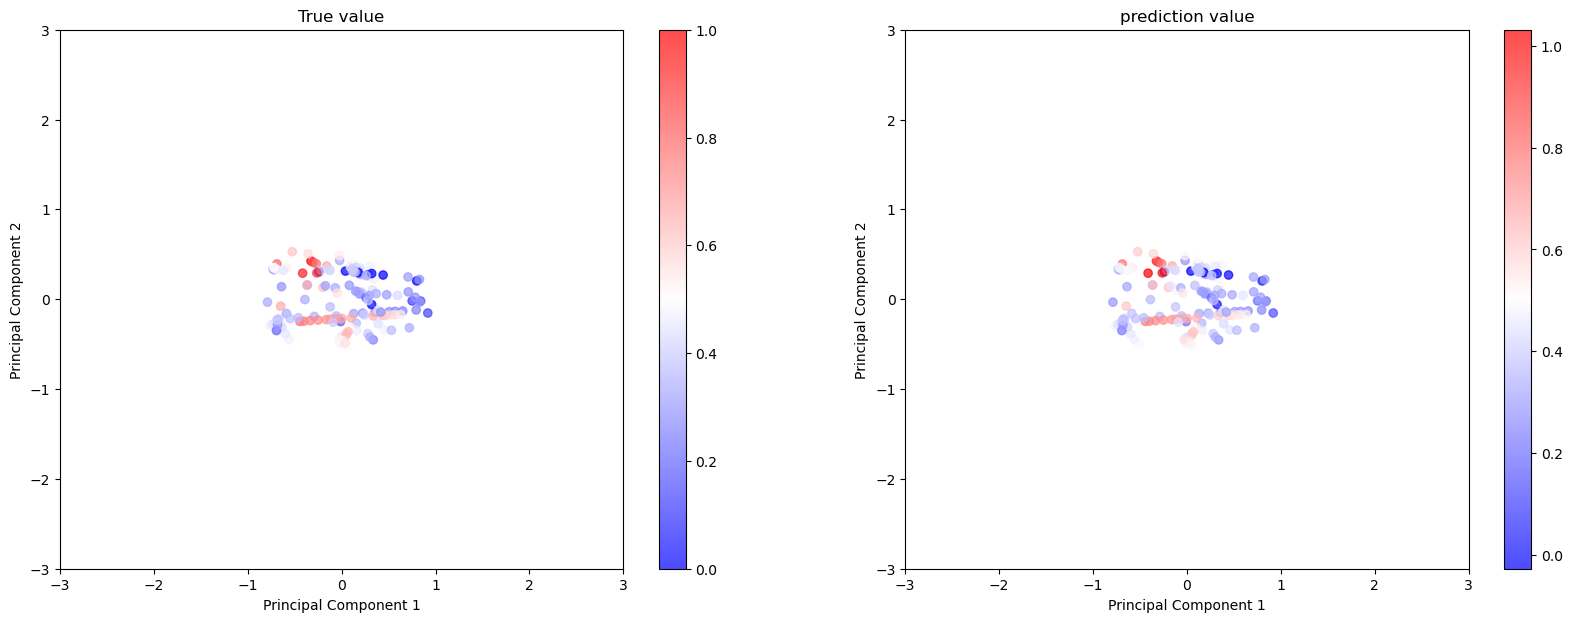

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 假設 encoder_model 是從autoencoder中提取的編碼部分
latent_vector = encoder.predict(data_scaled)
# 選取contour要呈獻的 vector
N_d =5
# 設置latent vector Z0, Z1 之範圍
xlim = 3
ylim = xlim

# 使用PCA將隱藏層(latent vectors)的向量壓縮到2維
pca = PCA(n_components=2)
latent_vector_2d = pca.fit_transform(latent_vector)
reconstructed_latent_vector_material_properties = decoder.predict(latent_vector)

######## for testing the inverse_transform of pca ###############
# reconstructed_latent_vector = pca.inverse_transform(latent_vector_2d)    #!!!
# reconstructed_latent_vector_material_properties = decoder.predict(reconstructed_latent_vector)    #!!!
######## for testing the inverse_transform of pca ###############


# 視覺化
plt.figure(figsize=(20, 7))

# 繪制第一個子圖
# plot the latent space in 2-d map
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
material_properties = data_scaled[:, N_d]
scatter1 = plt.scatter(latent_vector_2d[:, 0], latent_vector_2d[:, 1], alpha=0.7, c=material_properties, cmap='bwr')
plt.colorbar(scatter1)  # 添加色條
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('True value')
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
# plt.grid(True)
# plt.show()

# plot the latent space in 2-d map & validates inverse_transform of pca 
print(reconstructed_latent_vector_material_properties)
material_properties = reconstructed_latent_vector_material_properties[:, N_d]
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
scatter2 = plt.scatter(latent_vector_2d[:, 0], latent_vector_2d[:, 1], alpha=0.7, c=material_properties, cmap='bwr')
plt.colorbar(scatter2)  # 添加色條
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('prediction value')
# plt.title('pca inverse transform value')     #!!!

plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)

# plt.grid(True)
# plt.show()

# plt.subplot(1, 3, 3)  # (rows, columns, panel number)


117/117 [==============================] - 0s 1ms/step


(-3.0, 3.0)

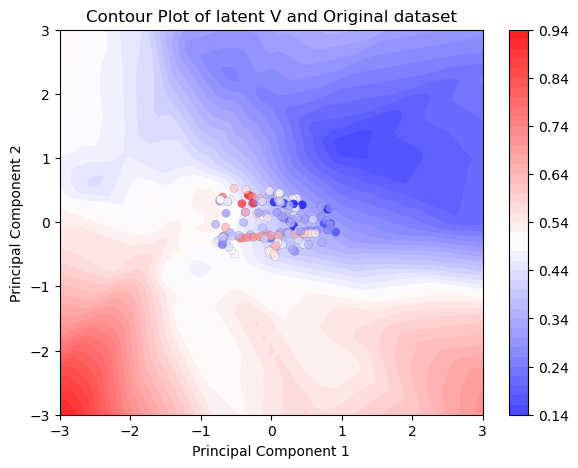

In [28]:
# 設定latent space視覺化空間
x = np.arange(-xlim, xlim+0.1, 0.1)
y = np.arange(-xlim, xlim+0.1, 0.1)
X, Y = np.meshgrid(x, y)
coordinates = np.stack([X.ravel(), Y.ravel()], axis=1)

# # latent_vector = encoder.predict(data_scaled)
# N_d =3
# # 假設 encoder_model 是從autoencoder中提取的編碼部分
# latent_vector = encoder.predict(data_scaled)
# pca = PCA(n_components=2)
# latent_vector_2d = pca.fit_transform(latent_vector)

# reconstruct 2-dimention pca vector to n-dimention latent vectors
reconstructed_latent_vector = pca.inverse_transform(coordinates)
reconstructed_latent_vector_material_properties = decoder.predict(reconstructed_latent_vector)

z_min = np.min(reconstructed_latent_vector_material_properties[:,N_d])
z_max = np.max(reconstructed_latent_vector_material_properties[:,N_d])
mp_min = np.min(data_scaled[:, N_d])
mp_max = np.max(data_scaled[:, N_d])

# 确定统一的颜色映射范围
vmin = min(z_min, mp_min)
vmax = max(z_max, mp_max)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)  # (rows, columns, panel number)
Z = reconstructed_latent_vector_material_properties[:, N_d].reshape(X.shape)  # 重新整形以匹配 X, Y
contour = plt.contourf(X, Y, Z, cmap='bwr', levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour)

material_properties = data_scaled[:, N_d]
scatter1 = plt.scatter(latent_vector_2d[:, 0], latent_vector_2d[:, 1], alpha=0.7, c=material_properties, cmap='bwr', edgecolors='black',linewidths=0.1, vmin=vmin, vmax=vmax)
# plt.colorbar(scatter1)  # 添加色條
plt.title('Contour Plot of latent V and Original dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim(-xlim, xlim)
plt.ylim(-ylim, ylim)
# plt.show()

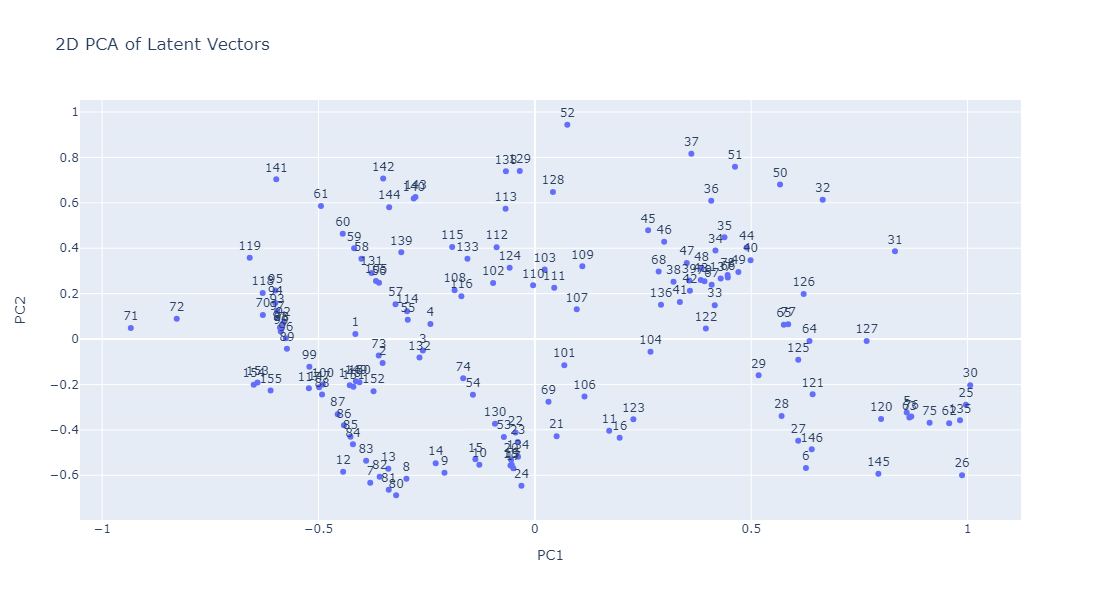

In [14]:
import plotly.express as px

# 前面步驟得到的PCA結果 latent_vector_2d
df_latent = pd.DataFrame(latent_vector_2d, columns=['PC1', 'PC2'])

# 為了在圖表上顯示每個點的索引，我們可以將索引作為一個列添加到DataFrame中
df_latent['Index'] = range(1, len(df_latent) + 1)

# 使用Plotly Express創建散點圖
fig = px.scatter(df_latent, x='PC1', y='PC2', text='Index', title='2D PCA of Latent Vectors')
fig.update_traces(textposition='top center')
fig.update_layout(height=600, width=800)
fig.show()

# Excise : Reduce the error when the predicted value is zero 